# Assignment 1 - __M&M Factory QA__

- To calculate:

    - [ ] Color distribuition. Must warn if any color is missing
    
    - [ ] Average shape area in mm and organized by color
    
[Documentation online](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html)



## A) Calibrate intrinsic paramenters and lens distortion of the camera. Show the intrinsic matrix and the lens distortion coeffiecients.
  

In [2]:
%pip install --upgrade pip
%pip install opencv-python
%pip install matplotlib
%pip install sympy
%pip install pandas
%pip install ipympl


#%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob
import sympy
import pandas as pd


  Using cached pip-23.0.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
Note: you may need to restart the kernel to use updated packages.
  Using cached opencv_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)
  Using cached numpy-1.24.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.7.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.2 MB)
  Using cached fonttools-4.39.3-py3-none-any.whl (1.0 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached contourpy-1.0.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached 

### __Detection of Checkboard__

In [ ]:
# tuple that says the grid size (note these are interior corners)
grid_size = (7,4) 

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((grid_size[1]*grid_size[0],3), np.float32)
objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = sorted(glob.glob('data/IntrinsicCalibration/calib_img_[0-9].png'))

for fname in images:

    print(f"Loading Image {fname}")
    img = cv.imread(fname)
    
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCornersSB(gray, grid_size, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, grid_size, corners2, ret)
        
    plt.subplot(1,2,2)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Detected')
    plt.show()


### __Calculating Intrinsic Camera Matrix__ 

In [ ]:
from sympy import *

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print(f" Intrinsic Matrix :")
pprint(sympy.Matrix(mtx).applyfunc(lambda x: Symbol('{:.3f}'.format(x))))

#print(f"\n Rotation Matrix : ")
#pprint(sympy.Matrix(rvecs))
#print(f"\n Translation Matrix : ")
#pprint(sympy.Matrix(tvecs))
# TO DO RODRIGUES ROTATION MATRIX TO VECTOR? 


### __UnWarp Images__

In [ ]:
images = sorted(glob.glob('data/IntrinsicCalibration/calib_img_[0-9].png'))
unwarped_img = []
for fname in images:

    print(f"Loading Image {fname}")
    img = cv.imread(fname)
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    plt.subplot(1,2,1)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original')
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))
    plt.title("Undistorted")
    plt.show()
    unwarped_img.append(dst)


In [ ]:
def old_way():
    #define range of red color in HSV from 0-180 range
    lower_red = np.array([np.max([0,(central_red-band_red)]), low_saturation, 0])
    upper_red = np.array([np.min([180,(central_red+band_red)]),255,255])

    lower_blue = np.array([np.max([0,(central_blue-band_blue)]), low_saturation, 0])
    upper_blue = np.array([np.min([180,(central_blue+band_blue)]),255,255])
    
    lower_yellow = np.array([np.max([0,(central_yellow-band_yellow)]) ,low_saturation  ,0  ])
    upper_yellow = np.array([np.min([180,(central_yellow+band_yellow)]) ,255,255])
    
    lower_green = np.array([np.max([0,(central_green-band_green)]) ,low_saturation  ,0  ])
    upper_green = np.array([np.min([180,(central_green+band_green)]) ,255,255])

    #Threshold the HSV image using inRange function to get only red colors
    mask_red = cv.inRange(hsv, lower_red, upper_red )
    mask_blue = cv.inRange(hsv, lower_blue, upper_blue )
    mask_yellow = cv.inRange(hsv, lower_yellow, upper_yellow )
    mask_green = cv.inRange(hsv, lower_green, upper_green )


In [ ]:
def plot_mask(mask, title):
    plt.imshow(mask, cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [ ]:
def calculate_boundary(center, margin, inputType='abs'): 
    inv = 0
    if inputType == 'abs':
        #from 0 to 255
        if center+margin > 255 :
            inv = 1
            lb = int(np.max([0, (center+margin)-255])) 
            hb = int(np.min([(center-margin),255]))
        elif  center-margin < 0:
            inv = 1
            lb = int(np.max([(center+margin), 0])) 
            hb = int(np.min([(255-np.abs(center-margin)),255]))
        else:
            lb = int(np.max([(center-margin),0]))
            hb = int(np.min([(center+margin),255])) 
    if inputType == 'deg':
        #from center 0 to 180
        center_deg = center*(255/180)
        margin_deg = margin*(255/180)
        lb = int(np.max([(center_deg-margin_deg)*ratio,0]))
        hb = int(np.min([(center_deg+margin_deg)*ratio,255])) # percentage of the range covered

    return (inv, [lb, hb])

In [ ]:
def segment_sat(img, thres):
    low_saturation = int(np.min([255,thres*2.55]))# in 0, 255 range 
    _, mask_sat =    cv.threshold(img, low_saturation, 255           , cv.THRESH_BINARY)
    
    #Clean up saturation mask
    kernel = np.ones((5, 5), np.uint8)
  
    # The first parameter is the original image,
    # kernel is the matrix with which image is
    # convolved and third parameter is the number
    # of iterations, which will determine how much
    # you want to erode/dilate a given image.

    sat_cleaned = cv.erode(mask_sat, kernel, iterations=7)
    sat_cleaned = cv.dilate(sat_cleaned, kernel, iterations=7)

    return sat_cleaned


In [ ]:
def background():
    mask_bg = segment_color(h, 155, 35)
    plot_mask(mask_bg, "background")
    positions = np.nonzero(mask_bg)
    top = positions[0].min()
    bottom = positions[0].max()
    left = positions[1].min()
    right = positions[1].max()

    nobg = img[top:bottom, left:right]
    plt.imshow(cv.cvtColor(nobg,cv.COLOR_BGR2RGB))
    plt.title("img cut")
    plt.axis("off")
    plt.show()

    output = cv.rectangle(img, (left, top), (right, bottom), (0,255,0), 1)
    plt.imshow(cv.cvtColor(img,cv.COLOR_BGR2RGB))
    plt.title("img with box")
    plt.axis("off")
    plt.show()

In [ ]:
def segment_color(hue, target, margin):    
    #the Hue is the component that can help us separate the candies.
    # We can assume that the M&M will be the most saturated thing 
    # in the picture. To address this we implement a high pass filter 
    # on the saturation channel

    max_hue = 180   #   account for full hsv or not cause idk what im doing by now
    if(np.max(hue) > 180):
        max_hue = 255

    inv, band = calculate_boundary(target, margin)

    if inv == 1:
        _, mask_l =    cv.threshold(hue, band[0]   , max_hue   , cv.THRESH_BINARY_INV)
        _, mask_h =    cv.threshold(hue, band[1]   , max_hue   , cv.THRESH_BINARY) 
        delta = cv.bitwise_or(mask_l,mask_h)
    elif inv == 0:
        _, mask_l =    cv.threshold(hue, band[0]   , max_hue   , cv.THRESH_BINARY)
        _, mask_h =    cv.threshold(hue, band[1]   , max_hue   , cv.THRESH_BINARY_INV) 
        delta = cv.bitwise_and(mask_l,mask_h)
    
    return delta


In [ ]:
def cleanup(mask, ks, e, d, n):
    # we could try and adjust the kernel to match the lighting source and try and remove the 
    # shadows that way but that would make the algorithm even more dependent on lighting
    
    #Clean up Color mask
    kernel = np.ones((ks, ks), np.uint8)
    # The first parameter is the original imagek,
    # kernel is the matrix with which image is
    # convolved and third parameter is the number
    # of iterations, which will determine how much
    # you want to erode/dilate a given image.
 
    for i in range(n):
        mask_clean = cv.erode(mask, kernel, iterations=e)
        mask_clean = cv.dilate(mask_clean, kernel, iterations=d) 
    
    mask_clean = cv.dilate(mask_clean, (5,5), iterations=2) 
        
    return mask_clean


In [ ]:
def composite_image(img, mask):
    gray = cv.cvtColor(cv.cvtColor(img,cv.COLOR_BGR2GRAY),cv.COLOR_GRAY2BGR)
    
    fg = cv.bitwise_and(cv.cvtColor(img,cv.COLOR_BGR2RGB), cv.cvtColor(img,cv.COLOR_BGR2RGB), mask=mask)

    background = np.full(img.shape, 255, dtype=np.uint8)
    bk = cv.bitwise_or(gray, gray, mask=cv.bitwise_not(mask))

    # combine foreground+background
    composite = cv.bitwise_or(fg, bk)


    return composite


In [ ]:
from random import randrange
def randomcolor():
    return (randrange(256),randrange(256),randrange(256))

#print(f"Random Color :{randomcolor()}")

### Average Blob Diameter

In [ ]:
# Find Average value for Blob diameter
# 
# Using the image with most M&Ms and we really just want to find the size of the candies so we will only use the saturation mask
images = sorted(glob.glob('data/WhiteBackground/calib_img_[0-9].png'))
stats = []

for fname in images:
    original = cv.imread(fname)
    _, s, _ = cv.split(cv.cvtColor(original, cv.COLOR_BGR2HSV_FULL))

    mask = segment_sat(s, 50)
    #plot_mask(mask, "Mask")

    params = cv.SimpleBlobDetector_Params()
    
    # Filter by Circularity
    params.filterByCircularity = False
    #params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = False
    #params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = False
    #params.minInertiaRatio = 0.01

    # Filter by Area
    params.filterByArea = False
    #params.minArea = 0.01
    #params.maxArea = 0.01


    params.filterByColor = True # THIS IS A binary image so the blob is always at max value
    params.blobColor = 255

    detector = cv.SimpleBlobDetector_create(params)
    # Detect blobs.
    keypoints = detector.detect(mask)

    i = 0
    for kp in keypoints:
        i += 1
        #print(f"Blob {i} has {kp.size} size)")
        stats.append(kp.size)

    gray = cv.cvtColor(cv.cvtColor(original,cv.COLOR_BGR2GRAY),cv.COLOR_GRAY2BGR)

    im_with_keypoints = cv.drawKeypoints(gray, keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Show blobs
    #plt.axis('off')
    #plt.title("Keypoints",)
    #plt.imshow(cv.cvtColor(im_with_keypoints, cv.COLOR_BGR2RGB))
    #plt.show()


dataframe = pd.Series(stats)


In [ ]:
print(f"High Margin {(dataframe.max() - dataframe.mean())*100/dataframe.mean():.1f}%")
print(f"Low Margin {(dataframe.mean() - dataframe.min())*100/dataframe.mean():.1f}%")
print(f"Center {0.5*(dataframe.max() + dataframe.min()):.0f}")
dataframe.describe()

Given the values of the cell above we can estimate that the largest diameter would be 110 and the smallest to be 50 meaning the radius are 55 and 25 respectively

### __Count Blobs__

In [ ]:
def countblobs(original, mask, string):
    # Setup SimpleBlobDetector parameters.
    params = cv.SimpleBlobDetector_Params()

    # Change thresholds -> no thresholding is already binary
    #params.minThreshold = 0
    #params.maxThreshold = 255

    # Filter by Area. This is pi times the (keypoint.size/2)^2 which is the diameter of the key points
    # since most key point hover around 100 diameter then we will give a 35% margin meaning the biggest
    # blob can have a 120 diamenter and the smallest 80. 
    params.filterByArea = False
    
    diam = 80
    margin = 0.35
    radius = diam/2
    
    #params.minArea = np.power(radius-margin*diam,2)*np.pi
    #params.maxArea = np.power(radius+margin*diam,2)*np.pi
    params.minArea = np.power(25,2)*np.pi
    params.maxArea = np.power(55,2)*np.pi
    
    # Filter by Circularity
    params.filterByCircularity = False
    #params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = False
    #params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = False
    #params.minInertiaRatio = 0.01

    params.filterByColor = True # THIS IS A binary image so the blob is always at max value
    params.blobColor = 255
    
    # Create a detector with the parameters
    # OLD: detector = cv2.SimpleBlobDetector(params)
    detector = cv.SimpleBlobDetector_create(params)


    # Detect blobs.
    keypoints = detector.detect(mask)
    
    #print(keypoints)
    
    # Draw detected blobs as red circles.
    # cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
    # the size of the circle corresponds to the size of blob
    
    gray = cv.cvtColor(cv.cvtColor(original,cv.COLOR_BGR2GRAY),cv.COLOR_GRAY2BGR)
    
    im_with_keypoints = cv.drawKeypoints(gray, keypoints, np.array([]), randomcolor(), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    # Show blobs
    # plt.axis('off')
    # plt.title(f"Keypoints {string}",)
    # plt.imshow(cv.cvtColor(im_with_keypoints, cv.COLOR_BGR2RGB))
    # plt.show()

    #print(f"Number of Keypoints: {len(keypoints)}")
    
    return (len(keypoints), gray)
    

In [ ]:
#NUMBER STATS
def numberstats():
    print(f"Image Shape {shape(h)}")
    print(f"Number of total pixels in image: {total}")
    
    print(f"Percentage of red Pixels: {num_red_pix/total:.3f}%")
    print(f"Percentage of blue Pixels: {num_blue_pix/total:.3f}%")
    print(f"Percentage of yellow Pixels: {num_yellow_pix/total:.3f}%")
    print(f"Percentage of green Pixels: {num_green_pix/total:.3f}%")
    
    print(f"Number of red pixels in image: {num_red_pix}")
    print(f"Number of blue pixels in image: {num_blue_pix}")
    print(f"Number of yellow pixels in image: {num_yellow_pix}")
    print(f"Number of green pixels in image: {num_green_pix}")

In [ ]:
def plot_results():
    # Display image using plt
    plt.figure(figsize=(40,40))

    plt.subplot(441)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(442)
    plt.imshow(h, cmap ="gray")
    plt.title("Hue")
    plt.axis("off")
    
    plt.subplot(443)
    plt.imshow(s, cmap="gray")
    plt.title("Saturation")
    plt.axis("off")

    plt.subplot(444)
    plt.imshow(mask_sat, cmap= "gray")
    plt.title("Sat Mask")
    plt.axis("off")

    plt.subplot(445)
    plt.imshow(mask_red, cmap="gray")
    plt.title("Red M&Ms")
    plt.axis("off")

    plt.subplot(446)
    plt.imshow(mask_blue, cmap="gray")
    plt.title("Blue M&Ms")
    plt.axis("off")
    
    plt.subplot(447)
    plt.imshow(mask_yellow, cmap="gray")
    plt.title("Yellow M&Ms")
    plt.axis("off")

    plt.subplot(448)
    plt.imshow(mask_green, cmap="gray")
    plt.title("Green M&Ms")
    plt.axis("off")

    plt.subplot(449)
    plt.imshow(mask_sat_red , cmap="gray")
    plt.title("Sat AND Red")
    plt.axis("off")

    plt.subplot(4,4,10)
    plt.imshow(mask_sat_blue , cmap ="gray")
    plt.title("Sat AND Blue")
    plt.axis("off")
    
    plt.subplot(4,4,11)
    plt.imshow(mask_sat_yellow , cmap="gray")
    plt.title("Sat AND Yellow")
    plt.axis("off")

    plt.subplot(4,4,12)
    plt.imshow(mask_sat_green, cmap= "gray")
    plt.title("Sat AND Green")
    plt.axis("off")

    plt.subplot(4,4,13)
    plt.imshow(final_red)
    plt.title("Composite Red")
    plt.axis("off")
    plt.subplot(4,4,14)
    plt.imshow(final_blue)
    plt.title("Composite Blue")
    plt.axis("off")
    plt.subplot(4,4,15)
    plt.imshow(final_yellow)
    plt.title("Composite Yellow")
    plt.axis("off")
    plt.subplot(4,4,16)
    plt.imshow(final_green)
    plt.title("Composite Green")
    plt.axis("off")



    plt.show()

In [ ]:
def countCandies(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV_FULL) #Because full h is now 8 bit - [0,255]
    
    global h, s, v
    h, s, v = cv.split(hsv)

    global mask_sat 
    global mask_red, mask_blue, mask_yellow, mask_green
    global mask_sat_red, mask_sat_blue, mask_sat_yellow, mask_sat_green
    global final_red, final_blue, final_yellow, final_green


    mask_sat = segment_sat(s, 50)

    ks = 3 #kernel Size
    e = 4 #erodes
    d = 6 #dilates
    n = 1 # number of cycles

    mask_red = cleanup(segment_color(h, 255, 15), ks, e ,d ,n)
    mask_blue = cleanup(segment_color(h, 146, 3), ks, e ,d ,n)
    mask_yellow = cleanup(segment_color(h, 35, 5), ks, e ,d ,n)
    mask_green = cleanup(segment_color(h, 100, 30), ks, e ,d ,n) # CHECK

    mask_sat_red = cleanup(cv.bitwise_and(mask_sat,mask_red), ks, e,d, n)
    mask_sat_blue = cleanup(cv.bitwise_and(mask_sat,mask_blue), ks, e,d, n)
    mask_sat_yellow = cleanup(cv.bitwise_and(mask_sat,mask_yellow), ks, e,d, n)
    mask_sat_green = cleanup(cv.bitwise_and(mask_sat,mask_green), ks, e,d, n)

    height, width = shape(h)
    total = height*width
    
    num_red_pix = cv.countNonZero(mask_sat_red)
    num_blue_pix = cv.countNonZero(mask_sat_blue)
    num_yellow_pix = cv.countNonZero(mask_sat_yellow)
    num_green_pix = cv.countNonZero(mask_sat_green)
    
    final_red = composite_image(img, mask_sat_red)
    final_blue = composite_image(img, mask_sat_blue)
    final_yellow = composite_image(img, mask_sat_yellow)
    final_green = composite_image(img, mask_sat_green)

    #Count blobs
    n_blobs_red, _ = countblobs(img, mask_sat_red, "Red")
    n_blobs_blue, _ = countblobs(img, mask_sat_blue, "Blue")
    n_blobs_yellow, _ = countblobs(img, mask_sat_yellow, "Yellow")
    n_blobs_green, _ = countblobs(img, mask_sat_green, "Green")
    
    print(f"We found {n_blobs_red} Red, {n_blobs_blue} Blue, {n_blobs_yellow} Yellow and {n_blobs_green} Green M&M's")

    plot_results()
    #numberstats()
    

In [ ]:
images = sorted(glob.glob('data/WhiteBackground/calib_img_[0-9].png'))

for fname in images:
    print(f"\n\nLoading Image {fname}\n")
    global img
    img = cv.imread(fname) # read image is BGR
    countCandies(img)

In [ ]:
images = sorted(glob.glob('data/GreyBackground/calib_img_[0-9].png'))

for fname in images:
    print(f"\n\nLoading Image {fname}\n")
    global img
    img = cv.imread(fname) # read image is BGR
    countCandies(img)

In [ ]:
img = cv.imread('data/WhiteBackground/calib_img_3.png')
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV_FULL) #Because full h is now 8 bit - [0,255]
h, s, v = cv.split(hsv)
plot_mask(v, "value")

# Size Calibration

[link](http://devres.zoomquiet.top/data/20160323135418/index.html)

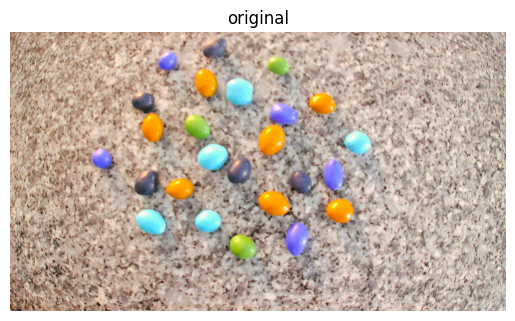

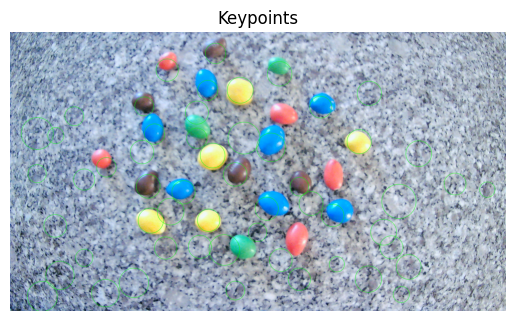

Number of Keypoints: 55


In [12]:
img = cv.imread("data/GreyBackground/calib_img_4.png")


plt.imshow(img)
plt.title("original")
plt.axis('off')
plt.show()


# Setup SimpleBlobDetector parameters.
params = cv.SimpleBlobDetector_Params()

# Change thresholds -> no thresholding is already binary
#params.minThreshold = 0
#params.maxThreshold = 255
# Filter by Area. This is pi times the (keypoint.size/2)^2 which is the diameter of the key points
# since most key point hover around 100 diameter then we will give a 35% margin meaning the biggest
# blob can have a 120 diamenter and the smallest 80. 
params.filterByArea = True
    
diam = 80
margin = 0.35
radius = diam/2
    
#params.minArea = np.power(radius-margin*diam,2)*np.pi
#params.maxArea = np.power(radius+margin*diam,2)*np.pi
params.minArea = np.power(25,2)*np.pi
params.maxArea = np.power(55,2)*np.pi
    
# Filter by Circularity
params.filterByCircularity = False
#params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = False
#params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = False
#params.minInertiaRatio = 0.01
params.filterByColor = False # THIS IS A binary image so the blob is always at max value
params.blobColor = 255
    
# Create a detector with the parameters
# OLD: detector = cv2.SimpleBlobDetector(params)
detector = cv.SimpleBlobDetector_create(params)
# Detect blobs.
keypoints = detector.detect(img)
    
    
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures
# the size of the circle corresponds to the size of blob
    
gray = cv.cvtColor(cv.cvtColor(img,cv.COLOR_BGR2GRAY),cv.COLOR_GRAY2BGR)
    
im_with_keypoints = cv.drawKeypoints(img, keypoints, np.array([]), (0,255,0), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    

plt.axis('off')
plt.title(f"Keypoints",)
plt.imshow(cv.cvtColor(im_with_keypoints, cv.COLOR_BGR2RGB))
plt.show()

print(f"Number of Keypoints: {len(keypoints)}")


In [11]:


# Load the image
img = cv.imread("data/GreyBackground/calib_img_4.png")


Red: 6 blob(s) found
Blue: 241 blob(s) found
Brown: 4 blob(s) found
No blobs found for color(s): Yellow, Green


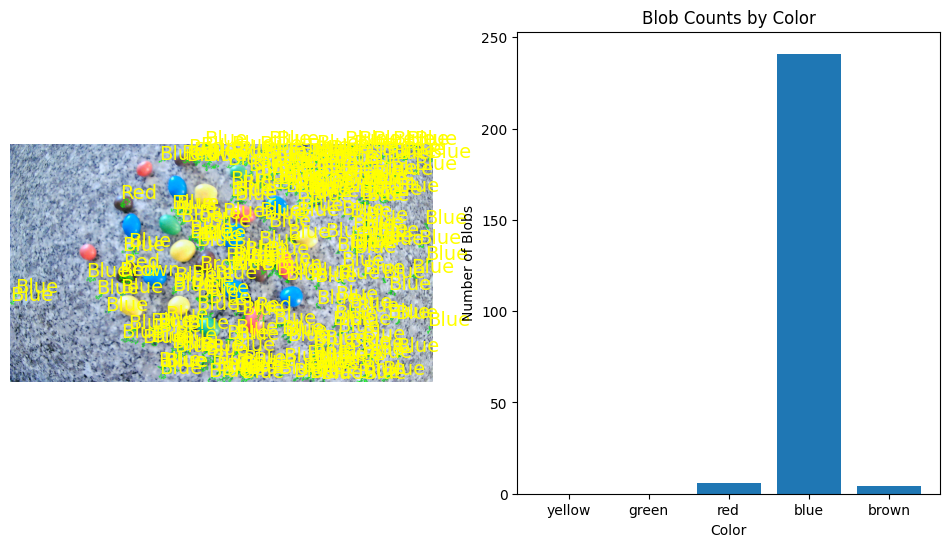

In [8]:

# Convert the image to HSV
hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# Define the range of blob sizes to detect
min_area = 100
max_area = 1000

# Define the ranges of hue values for each color
hue_ranges = {
    'yellow': (20, 40),
    'green': (40, 80),
    'red': (0, 10),
    'blue': (100, 130),
    'brown': (10, 20)
}

# Initialize a dictionary to store the counts of each color
color_counts = {color: 0 for color in hue_ranges}

# Loop through each hue range and find the blobs that fall within the range
for color, hue_range in hue_ranges.items():
    mask = cv.inRange(hsv_img, (hue_range[0], 50, 50), (hue_range[1], 255, 255))
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv.contourArea(contour)
        if min_area < area < max_area:
            color_counts[color] += 1

# Print the counts of each color and report if any color is missing
missing_colors = []
for color, count in color_counts.items():
    if count > 0:
        print(f'{color.capitalize()}: {count} blob(s) found')
    else:
        missing_colors.append(color.capitalize())
if missing_colors:
    missing_colors_str = ', '.join(missing_colors)
    print(f'No blobs found for color(s): {missing_colors_str}')

# Display the image with blobs highlighted
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
ax1.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
for color, hue_range in hue_ranges.items():
    mask = cv.inRange(hsv_img, (hue_range[0], 50, 50), (hue_range[1], 255, 255))
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        area = cv.contourArea(contour)
        if min_area < area < max_area:
            color_name = color.capitalize()
            cv.drawContours(img, contour, -1, (0, 255, 0), 2)
            x, y, w, h = cv.boundingRect(contour)
            ax1.text(x, y, color_name, color='yellow', fontsize=14)
ax1.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax1.set_axis_off()

# Create a bar graph of the number of blobs found for each color
colors = list(hue_ranges.keys())
counts = [color_counts[color] for color in colors]
ax2.bar(colors, counts)
ax2.set_xlabel('Color')
ax2.set_ylabel('Number of Blobs')
ax2.set_title('Blob Counts by Color')

plt.show()


In [14]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

%matplotlib widgets

# Initialize sliders
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)
diam_slider_ax = plt.axes([0.2, 0.1, 0.6, 0.03])
margin_slider_ax = plt.axes([0.2, 0.05, 0.6, 0.03])
diam_slider = Slider(diam_slider_ax, 'Diameter', 0, 500, valinit=50)
margin_slider = Slider(margin_slider_ax, 'Margin', 0, 500, valinit=10)

# Convert the image to HSV
hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV_FULL)

# Define the range of colors
color_range = {
    "yellow": [(20, 100, 100), (30, 255, 255)],
    "green": [(50, 100, 100), (70, 255, 255)],
    "red": [(0, 100, 100), (10, 255, 255)],
    "blue": [(110, 100, 100), (130, 255, 255)],
    "brown": [(0, 20, 40), (20, 255, 255)]
}

# Define the diameter and margin thresholds based on the sliders
diameter = int(diam_slider.val)
margin = int(margin_slider.val)

# Define the minimum and maximum area thresholds based on the diameter
min_area = np.pi * ((diameter/2 - margin) ** 2)
max_area = np.pi * ((diameter/2 + margin) ** 2)

# Find the blobs in the image
blobs = {}
for color, (lower, upper) in color_range.items():
    # Create a mask for the color range
    mask = cv.inRange(hsv_img, np.array(lower), np.array(upper))

    # Find the contours in the mask
    contours, hierarchy = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Filter the contours by area
    filtered_contours = [contour for contour in contours if min_area < cv.contourArea(contour) < max_area]

    # Add the blobs to the dictionary
    if filtered_contours:
        blobs[color] = len(filtered_contours)
    else:
        print(f"No {color} blobs found.")

# Print the results
for color, count in blobs.items():
    print(f"Found {count} {color} blobs.")

# Plot the image and the bar graph
ax_image = plt.subplot(121)
ax_image.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
ax_image.set_title('Original Image')

ax_bars = plt.subplot(122)
ax_bars.bar(blobs.keys(), blobs.values(), color=blobs.keys())
ax_bars.set_title('Blob Count by Color')

# Define the slider update functions
def update_diam(val):
    global diameter, min_area, max_area
    diameter = int(val)
    min_area = np.pi * ((diameter/2 - margin) ** 2)
    max_area = np.pi * ((diameter/2 + margin) ** 2)
    update_bars()

def update_margin(val):
    global margin, min_area, max


KeyError: 'widgets'